# Yandex Data Science School
## Linear Regression & Regularization Solution.
### Written by Dr. Hanan Shteingart.

## Solution 1

In [ ]:
# * What is $p$? what is $n$ in the above notation? hint: [shape](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.ndarray.shape.html)

from sklearn.datasets import load_boston
import numpy as np
%pylab inline
#load data
from sklearn.preprocessing import normalize

X, Y = load_boston(True)
X = normalize(X)
n,p = X.shape
print('n={} samples, p={} features'.format(n,p))

Populating the interactive namespace from numpy and matplotlib
n=506 samples, p=13 features


In [ ]:
# * write a model `Ols` which has a propoery $w$ and 3 methods: `fit`, `predict` and `score`.? hint: use [numpy.linalg.pinv](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.linalg.pinv.html) to be more efficient.

class Ols(object):
  def __init__(self):
    self.w = None
    
  @staticmethod
  def pad(X):
    return np.pad(X, ((0,0),(1,0)), 'constant', constant_values=1)
  
  def fit(self, X, Y):
    if len(Y.shape)==1:
      Y = Y.reshape(-1,1)
    self._fit(self.pad(X), Y)
    return self
  
  def _fit(self, X, Y):
    Xpinv = np.linalg.pinv(X)
    self.w = np.dot(Xpinv, Y)
    
  def predict(self, X):
    if self.w is None:
      raise ValueError('model was not fitted')
    return self._predict(self.pad(X))
    
  def _predict(self, X):
    Yest = np.dot(X, self.w)
    return Yest
  
  def score(self, X, Y):
    if len(Y.shape)==1:
      Y = Y.reshape(-1,1)
    Yest = self.predict(X)
    MSE = np.square(Yest - Y).mean()
    return MSE

In [ ]:
# * Fit the model. What is the training MSE?
model = Ols()
model.fit(X,Y)
MSE = model.score(X,Y)
print('Training MSE = {:3.2f}'.format(MSE))

Training MSE = 21.60


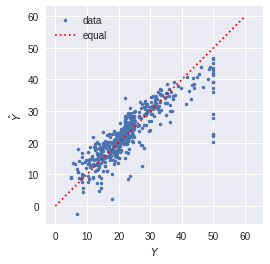

In [ ]:
# * Plot a scatter plot where on x-axis plot $Y$ and in the y-axis $\hat{Y}_{OLS}$
Yest = model.predict(X)
plt.plot(Y, Yest, '.', label='data')
plt.xlabel('$Y$')
plt.ylabel('$\hat{Y}$')
plt.xlim(0,60)
plt.ylim(0,60)
plt.plot(plt.xlim(), plt.xlim(), 'r:', label='equal')
plt.legend()
plt.axis('square');

In [ ]:
# * Split the data to 75% train and 25% test 20 times. What is the average MSE now for train and test? hint: use [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) or [ShuffleSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html).

from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.metrics import mean_squared_error
from scipy.stats import ttest_rel
mse_train = []
mse_test = []
for trn, tst in ShuffleSplit(n_splits=20, test_size=0.25).split(X, Y):  
  X_trn, Y_trn = X[trn], Y[trn]
  X_tst, Y_tst = X[tst], Y[tst]
  model.fit(X_trn, Y_trn)
  mse_train.append(model.score(X_trn, Y_trn))
  mse_test.append(model.score(X_tst, Y_tst))
mmse_train = np.mean(mse_train)
mmse_test = np.mean(mse_test)
print(mmse_train, mmse_test)
ttest_rel(mse_train, mse_test)

(21.156239464725395, 23.955552890018005)


Ttest_relResult(statistic=-1.6287929846232896, pvalue=0.11982500515253404)

In [ ]:
# Write a new class OlsGd which solves the problem using gradinet descent. 
# The class should get as a parameter the learning rate and number of iteration. 
# Plot the loss convergance. 
# What is the effect of learning rate? 
# How would you find number of iteration automatically? 
# Note: Gradient Descent does not work well when features are not scaled evenly (why?!). Be sure to normalize your feature first.
class Normalizer():
  def __init__(self):
    self.mean = None
    self.std = None
  def fit(self, X):
    self.mean = X.mean()
    self.std = X.std()
  def predict(self, X):
    if (self.mean is None) or (self.std is None):
      raise ValueError('you should call fit before predict')
    return (X-self.mean)/self.std
    
class OlsGd(Ols):
  
  def __init__(self, learning_rate=.05, 
               num_iteration=1000, 
               normalize=True,
               early_stop=True,
               verbose=True):
    
    super(OlsGd, self).__init__()
    self.learning_rate = learning_rate
    self.num_iteration = num_iteration
    self.early_stop = early_stop
    self.normalize = normalize
    self.normalizer = Normalizer()    
    self.verbose = verbose
    
  def _fit(self, X, Y, reset=True, track_loss=True):
    Xorig = X
    if self.normalize:
      self.normalizer.fit(X)
      X = self.normalizer.predict(X)
    if (self.w is None) or reset:
      self.w = np.zeros((X.shape[1],1))
    self.loss = []
    for iter in range(self.num_iteration):
      if self.verbose:
        print('iter %d/%d'%(iter, self.num_iteration))
      self._step(X,Y)
      if track_loss:
        loss = self.score(Xorig[:,1:],Y) # get rid of the padded 1, use Xorig otherwise it will be padded twice
        if self.verbose:
          print(loss)
        self.loss.append(loss)
        if self.early_stop and (len(self.loss)>=2) and (self.loss[-2] < self.loss[-1]):
          if self.verbose:
            print('loss is not decreasing')
          break
        
  def _predict(self, X):
    if self.normalize:
      if self.verbose:
        print('normalizing X')
      X = self.normalizer.predict(X)
    return super(OlsGd, self)._predict(X)
  
  def _step(self, X, Y):
      n = X.shape[0]
      Yhat = np.dot(X, self.w)
      err =  Yhat - Y
      grad = np.dot(X.T, err)/n
      self.w = self.w - self.learning_rate * grad

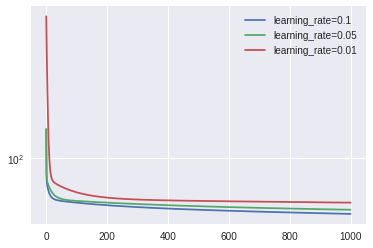

In [ ]:
model = OlsGd(verbose=False)
for learning_rate in [0.1, 0.05, 0.01]:
  model.learning_rate = learning_rate
  model.fit(X,Y)
  plt.semilogy(model.loss, label='learning_rate={}'.format(model.learning_rate))
plt.legend()

In [ ]:
class OlsCd(Ols):
  """coordinate descent"""
  
  def __init__(self, 
               num_iteration=10, 
               verbose=True):
    super(OlsCd, self).__init__()
    self.num_iteration = num_iteration
    self.verbose = verbose
    self.loss = []
    
  def _fit(self, X, Y, reset=True, track_loss=True):
    if (self.w is None) or reset:
      self.w = np.zeros((X.shape[1],1))
    for iter in range(self.num_iteration):
      if track_loss:
        loss = self.score(X[:,1:],Y) # get rid of the padded 1, use Xorig otherwise it will be padded twice
        if self.verbose:
          print(loss)
        self.loss.append(loss)
      if self.verbose:
        print('iter %d/%d'%(iter, self.num_iteration))
      self._step(X,Y)
          
  def _step(self, X, Y):
    n, p = X.shape
    for i in range(p):
      X_not_i = np.delete(X, i, axis=1)
      w_not_i = np.delete(self.w, i, axis=0)
      Xi = X[:,i]
      Yhat_i = np.dot(X_not_i, w_not_i) 
      wi = -np.dot(Xi.T, Yhat_i-Y)/np.dot(Xi.T, Xi)
      self.w[i] = wi

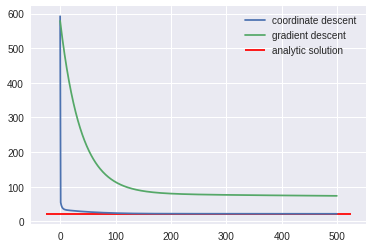

In [ ]:
from sklearn.preprocessing import normalize
model = OlsCd(num_iteration=500, verbose=False)
Xnormalized = normalize(X)
model.fit(Xnormalized,Y)
model.score(Xnormalized,Y)
plt.plot(model.loss, label='coordinate descent')
plt.hlines(MSE, *plt.xlim(), color='r', label='analytic solution')
model = OlsGd(learning_rate=0.001, verbose=False, num_iteration=500)
model.fit(X,Y)
plt.plot(model.loss, label='gradient descent')
plt.legend()

## Solution 2

In [ ]:
class RidgeLs(Ols):
  def __init__(self, ridge_lambda, *wargs, **kwargs):
    super(RidgeLs,self).__init__(*wargs, **kwargs)
    self.ridge_lambda = ridge_lambda
    
  def _fit(self, X, Y):
    C = np.dot(X.T,X)
    L = self.ridge_lambda * np.eye(X.shape[1])
    CLinv = np.linalg.inv(C+L)
    Xpinv = np.dot(CLinv, X.T)
    self.w = np.dot(Xpinv, Y)


In [ ]:
X, Y = load_boston(True)
from sklearn.preprocessing import normalize
X = normalize(X)
from sklearn.model_selection import train_test_split, ShuffleSplit, KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import ttest_rel
mse_train = []
mse_test = []
#model = RidgeLs(ridge_lambda=0.001)
model = Ols()
for trn, tst in KFold(10).split(X, Y):  
  X_trn, Y_trn = X[trn], Y[trn]
  X_tst, Y_tst = X[tst], Y[tst]
  model.fit(X_trn, Y_trn)
  mse_train.append(model.score(X_trn, Y_trn))
  mse_test.append(model.score(X_tst, Y_tst))
mmse_train = np.mean(mse_train)
mmse_test = np.mean(mse_test)
print(mmse_train, mmse_test)
ttest_rel(mse_train, mse_test)

(21.282346263618162, 29.505302590421717)


Ttest_relResult(statistic=-0.5920195950624112, pvalue=0.5684095445536452)

In [ ]:
from sklearn.datasets import load_diabetes
X, Y = load_diabetes(True)
from sklearn.linear_model import Ridge as Ridge, LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
for model in [LinearRegression(), RidgeCV(normalize=True), LassoCV(normalize=True)]:
  score = cross_val_score(model, X,Y, scoring='neg_mean_squared_error',cv=10)
  print(-score.mean(), model.__class__.__name__)

(3000.3810328390514, 'LinearRegression')
(2999.5520825101544, 'RidgeCV')
(3014.1809358291275, 'LassoCV')


In [ ]:
model = Ridge()
X, Y = load_boston(True)
model.fit(X,Y)
model.score(X,Y)
print(mean_squared_error(Y, model.predict(X)))

22.044452243088195


In [ ]:
from sklearn.model_selection import validation_curve

## The noise equaivalent of ridge regression was suppose to be an analytical question. The solution is given in [this blogpost](http://madrury.github.io/jekyll/update/statistics/2017/08/12/noisy-regression.html)

